In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torchvision
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import numpy as np
import pytorchtools as pt
import pytorch_metric_learning.losses as losses
%matplotlib notebook

In [2]:
NUM_WORKERS = 8
BATCH_SIZE = 128
INPUT_SIZE = 128
LR = 1e-4
NUM_EPOCHS = 10
DEVICE = "cuda:0"

NORMALIZED_FEATURES = True

# Model

In [3]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
nn.init.xavier_normal_(model.fc.weight)

monitor = pt.ForwardMonitor(model, verbose=False)
monitor.add_layer("fc")


# Datasets

In [4]:
# Train loader
tr_train = T.Compose([T.Resize((INPUT_SIZE, INPUT_SIZE)),
                      T.RandomHorizontalFlip(),
                      T.ColorJitter(.1,.1,.1),
                      T.ToTensor()])

data_train = CIFAR10(root=".",train=True,transform=tr_train,download=True)
load_train = torch.utils.data.DataLoader(data_train,
                                         num_workers=NUM_WORKERS,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         drop_last=True)

Files already downloaded and verified


In [5]:
# test loader
tr_test = T.Compose([T.Resize((INPUT_SIZE, INPUT_SIZE)),
                      T.ToTensor()])

data_test = CIFAR10(root=".",train=False,transform=tr_test)
load_test = torch.utils.data.DataLoader(data_test,
                                         num_workers=NUM_WORKERS,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

# Optimization

In [22]:
optim = torch.optim.Adam(model.parameters(), lr=LR)

In [23]:
C = 10
Pw = 0.95
minimum_s = np.log((C-1)*Pw/(1-Pw))*(C-1)/C

margin = C/(C-1)

print("scale", minimum_s)
print("margin", margin)

scale 4.6274972008523925
margin 1.1111111111111112


In [24]:

criterion = losses.CosFaceLoss(embedding_size=2, margin=margin, scale=minimum_s, num_classes=10)
optim_loss = torch.optim.Adam(criterion.parameters(), lr=1e-3)

# Training

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
def visualize_features(fig, ax, features, labels, normalize=False, title=""):
    ax.clear()
    if normalize:
        norm = np.linalg.norm(features, axis=1)
        features = features / norm.reshape(-1,1)
    scatter = ax.scatter(features[:,0],
                  features[:,1],
                  s = 10,
                  c=labels,
                  cmap="Paired")
    ax.legend(handles=scatter.legend_elements()[0],
                 labels=data_train.classes,
                 loc="upper right",
                fontsize=8)
    
    ax.title.set_text(title)

    fig.canvas.draw()
    fig.canvas.flush_events()

<IPython.core.display.Javascript object>


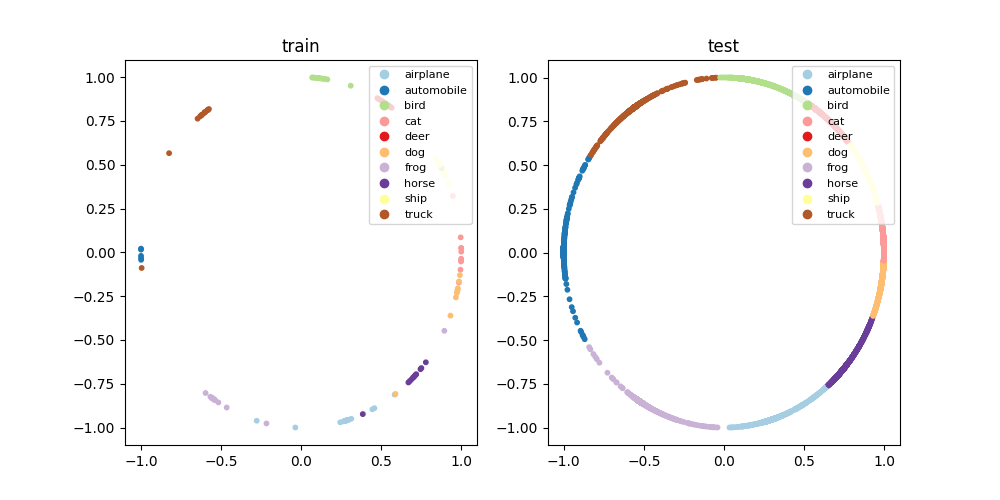

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 67.9400


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 77.8000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 81.0700


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 83.8700


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 84.5700


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 86.3300


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 84.2700


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 84.7500


  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.ion()

n_iter_train = len(load_train)
n_iter_test = len(load_test)
model.to(DEVICE)
criterion.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    model.train()
    criterion.train()
    feature_points = []
    label_values = []
    for iter, (images, labels) in enumerate(tq.tqdm(load_train)):
        optim.zero_grad()
        optim_loss.zero_grad()
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        out = model(images)

        loss = criterion(out, labels)
        loss.backward()

        optim.step()
        optim_loss.step()
        
        if iter % int(.1*n_iter_train) == 0:
            features_val = monitor.get_layer("fc").detach().squeeze(-1).squeeze(-1).cpu().numpy()
            label_values.append(labels.cpu().numpy())
            feature_points.append(features_val)
            
            visualize_features(fig,
                               ax[0],
                               np.vstack(feature_points),
                               np.concatenate(label_values),
                               normalize=NORMALIZED_FEATURES,
                               title="train")

    # test
    features_test = []
    y_pred = []
    y_test = []
    model.eval()
    criterion.eval()
    for iter, (images, labels) in enumerate(tq.tqdm(load_test)):
        images = images.to(DEVICE)
        y_test.append(labels.cpu().numpy())
        with torch.no_grad():
            out = model(images)
            out = criterion.get_logits(out)
        
        y_pred.append(torch.argmax(out, 1).cpu().numpy())
        features = monitor.get_layer("fc").squeeze(-1).squeeze(-1).cpu().numpy()
        features_test.append(features)
            
        if iter % int(0.1*n_iter_test) == 0:
            visualize_features(fig,
                               ax[1],
                               np.vstack(features_test),
                               np.concatenate(y_pred),
                               normalize=NORMALIZED_FEATURES,
                               title="test")
    
    test_acc = accuracy_score(np.concatenate(y_test), np.concatenate(y_pred))
    print(f"Test Accuracy {test_acc*100:.4f}")